# Классификация текстов с использованием BERT для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-тетради" data-toc-modified-id="Подготовка-тетради-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка тетради</a></span></li><li><span><a href="#Предварительный-анализ-данных" data-toc-modified-id="Предварительный-анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предварительный анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-датафрейма-на-выборки" data-toc-modified-id="Разделение-датафрейма-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение датафрейма на выборки</a></span></li><li><span><a href="#Полезные-функции" data-toc-modified-id="Полезные-функции-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Полезные функции</a></span></li><li><span><a href="#Процесс-обучения" data-toc-modified-id="Процесс-обучения-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Процесс обучения</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Подготовка тетради

In [1]:
import numpy as np
import pandas as pd
import time # Оценка времени выполнения кода
import os # Загрузка датафрейма

# BERT
import torch
import transformers
from tqdm import notebook

# Работа с датафреймом
from sklearn.model_selection import(
    cross_val_score, 
    train_test_split 
) 

# Предобработка данных
from sklearn.preprocessing import(
    StandardScaler # стандартизация
    #MaxAbsScaler, # стандартизация по максимальному абсолютном значению в пределах 0-1
    #normalize # нормализация значений аттрибутов
) 

# Автоматизация раздельного декодирования признаков
from sklearn.compose import(
    #make_column_selector, 
    #make_column_transformer, 
    ColumnTransformer
)

# Pipeline (пайплайн)
!pip install imblearn
#!pip install -U imblearn
#!pip install -U imbalanced-learn
#conda install -c conda-forge imbalanced-learn
#conda install -c glemaitre imbalanced-learn
from imblearn.pipeline import Pipeline # Более предпочтительнее для TfidfVectorizer
from imblearn.over_sampling import SMOTE # Балансировка классов в Pipeline
#from sklearn.pipeline import make_pipeline # Pipeline с автоматическим названием шагов.
# Функция для поддержки экспериментальной функции HavingGridSearchSV
from sklearn.experimental import enable_halving_search_cv
# Ускоренная автоматизация поиска лучших моделей и их параметров
from sklearn.model_selection import HalvingGridSearchCV
# Ускоренная автоматизация рандомного поиска лучших моделей и их параметров
#from sklearn.model_selection import HalvingRandomSearchCV

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB # Улучшенный классификатор для не сбалансированных классов
from catboost import CatBoostClassifier # CatBoost (Яндекс). Классификация

# Метрики
from sklearn.metrics import f1_score # F1 - среднегармоническое между precision_score и recall_score

# Визуализация графиков
import seaborn as sns
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from pandas.plotting import scatter_matrix


In [2]:
# Отображение всех столбцов таблицы
pd.set_option('display.max_columns', None)
# Обязательно для нормального отображения графиков plt
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
# Дополнительно и не обязательно для декорирования графиков
factor = .8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor


In [3]:
STATE = 42

### Предварительный анализ данных

In [4]:
# Загрузка данных
if os.path.exists('datasets/toxic_comments.csv'):
    data = pd.read_csv('toxic_comments.csv')
elif os.path.exists('/datasets/toxic_comments.csv'):
    data = pd.read_csv('/datasets/toxic_comments.csv')
else:
    print('Файл не найден')


In [5]:
# Анализ датафрейма
print(data.info())
data.sample(n=10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


,Unnamed: 0,text,toxic
55251,55312,"""\nAre you saying that I sir, am no gentleman?...",0
99206,99302,"Ok, I do apologise for my slight outburst abov...",0
51491,51548,"Eh, I think it's just going to look stupid as ...",0
53230,53291,References to the E line\nwhat are all these r...,0
46732,46787,"""\nFastfission, I welcome your thoughts on the...",0
126954,127085,Brasília \nPlease be careful not to remove con...,0
149991,150147,"""\nOh yes, you should ask him again. He copy-e...",0
99692,99789,All-Soviet Peace Conference\nTo nominate for d...,0
84387,84468,You don't know if it's a fraud or not. Let's a...,0
55999,56060,There does not seem to be a cohesive entity ca...,0


In [6]:
# Анализ уникальных значений 
# категориального признака "text"
data.toxic.unique()


array([0, 1])

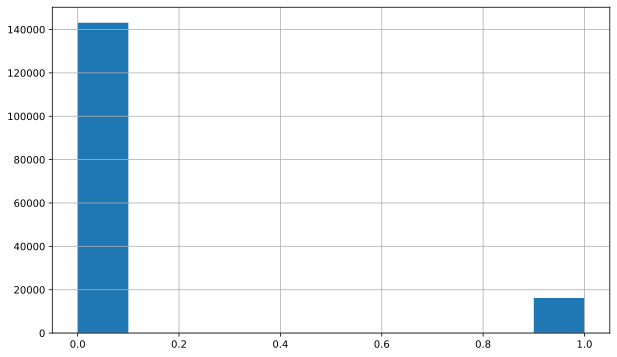

In [7]:
# Анализ баланса классов
# целевой переменной
data['toxic'].hist(); 


**Вылов из предварительного анализа данных**
1. Датафрейм содержит 159292 объекта без пропусков и 3 признака. Признак `text` содержит исходные тексты твитов, является не целевым и будет использован в обучении и предсказании. Признак `toxic` содержит данные по классификации текстов и явялется целевым.
1. Признак `toxic` содержит только `0` и `1`, но, при этом, имеет тип данных `int64`. Его следует оптимизировать до `uint8`.
1. Признак `toxic` является целевыми с не сбалансированными классами и многократным перевесом в пользу класса `0`. Этот файкт требуется учесть при делении датафрейма на обучающие и тестовые выборки.
1. Признак `Unnamed: 0` не содержит ценной для обучения информации и не будет использован в дальнейшем анализе и обучении моделей.


### Предобработка данных

In [8]:
# Ограничение выборки для ускорения проверки кода
# путем выбора n количества случайных объектов
data = data.sample(n=500, random_state=STATE)


In [9]:
# Оптимизация данных
data['toxic'] = data['toxic'].astype('uint8')


In [10]:
# Загрузка словаря модели BERT
tokenizer = transformers.BertTokenizer(
    vocab_file='/datasets/ds_bert/vocab.txt')


In [11]:
# Токенизация текстов твитов 
# с добавлением токенов начала и конца текста
tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))


In [12]:
# Определение максимальной длины токена
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

print('Максимальная длина токена:', max_len) 


Максимальная длина токена: 1438


In [13]:
# Приведение токенов к единой максимальной длине
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# Уменьшение размерности токенов
padded = padded[:, :512] 


In [14]:
# "Маскировка" нулями (пустота) и единицами (текст) токенов.
attention_mask = np.where(padded != 0, 1, 0)


In [15]:
# Инициализация модели класса "BertModel",
# паередача ей данных из файлов предобученной модели
# и конфигурации
config = transformers.BertConfig.from_json_file(
    '/datasets/ds_bert/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/datasets/ds_bert/rubert_model.bin', config=config)

Some weights of the model checkpoint at /datasets/ds_bert/rubert_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
batch_size = 2
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch) 
    
    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 
    

  0%|          | 0/250 [00:00<?, ?it/s]

## Обучение

### Разделение датафрейма на выборки

In [17]:
# Разделение датафрейма 
# на целевые и не целевые выборки
#features = data['text']
features = np.concatenate(embeddings)
target = data['toxic']

# Разделение выборок 
# на обучающие и тестовые
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=.25, 
    stratify=target, 
    random_state=STATE
) 


### Полезные функции

In [18]:
# Model + Params + Pipeline + HalvingGridSearchCV
def model_pipeline_gridsearch(
    features_train, 
    target_train, 
    model, 
    params, 
    data_grids, 
    data_times 
):
    
    # Начало отслеживания времени
    start_time = time.time() 
    
    # Pipeline
    pipeline = Pipeline([
        #('vect', ColumnTransformer([
            #('tfidf', TfidfVectorizer(), 'corpus'), # векторизация текстов
            #('std', StandardScaler(), features_train[['numbers_of_words', 'average_word_lenght']].columns) # (возвращает ошибку на всем объёме данных) стандартизация данны
            #('stdm', MaxAbsScaler(), features_train[['numbers_of_words', 'average_word_lenght']].columns) # (возвращает ошибку на всем объёме данных) стандартизация данны
            #('norm', normalize(), features_train[['numbers_of_words', 'average_word_lenght']].columns) 
        #], remainder='drop' # удаление исходного атрибута с текстами
        #)), 
        ('sampl', SMOTE(random_state=STATE)), # сэмплирование данных (приведение классов в равновесие) за счет создания синтетических данных из минорного класса
        ('clf', model) # модель классификации 
    ])
    
    # HalvingGridSearchCV
    # (о подборе оптимальных параметров:
    # https://scikit-learn.ru/3-2-tuning-the-hyper-parameters-of-an-estimator/)
    #grid = HalvingRandomSearchCV(
    grid = HalvingGridSearchCV(
        pipeline, 
        params, 
        #resorce=
        cv=4, # параметр KFold для кроссвалидации (обучющая и валидационная выборки 75:25)
        n_jobs=-1, # количество параллельно выполняемых заданий (-1 - задействованы все процессоры)
        scoring='f1', # функция ошибки
        error_score='raise', #0 # в случае неполадки 'raise' - возвращает ошибку, int - возвращает FitFailedWarning
        random_state=STATE
    ) 
    
    # Обучение
    grid.fit(features_train, target_train)
    
    # Подсчет времени выполнения скрипта
    finish_time = time.time()
    funtion_time = finish_time - start_time
    
    data_grids.append(grid)
    data_times.append(funtion_time) 
    
    return data_grids, data_times


In [19]:
# Вывод на печать результатов модели
def print_model_result(grids, data_times, model_name):
    print('Модель    :', model_name)
    print('Метрика F1:', grids[-1].best_score_)
    print(f'Время     : {data_times[-1]} секунд')
    print('Параметры :', grids[-1].best_estimator_[-1].get_params())
    print()
    print('-'*20)
    print()


### Процесс обучения

In [20]:
# Поиск лучших моделей и их параметров
data_grids = []
data_times = []


In [21]:
# LogisticRegression
params = [{
    # Параметры модели
    'clf__solver': ('liblinear', 'lbfgs') 
}]
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    LogisticRegression(
        random_state=STATE
    ), 
    params, 
    data_grids, 
    data_times 
)
print_model_result(data_grids, data_times, 'LogisticRegression')


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Модель    : LogisticRegression
Метрика F1: 0.32591706539074955
Время     : 8.158280372619629 секунд
Параметры : {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--------------------



In [22]:
# LogisticRegression
best_solver = data_grids[-1].best_estimator_[-1].get_params()['solver'] 
params = [{
    # Параметры модели
    'clf__penalty': ('l1', 'l2'), #, None), 
}]
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    LogisticRegression(
        random_state=STATE, 
        solver=best_solver
    ), 
    params, 
    data_grids, 
    data_times 
)
print_model_result(data_grids, data_times, 'LogisticRegression')


Модель    : LogisticRegression
Метрика F1: 0.32591706539074955
Время     : 2.1511740684509277 секунд
Параметры : {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--------------------



In [23]:
# LogisticRegression
best_penalty = data_grids[-1].best_estimator_[-1].get_params()['penalty'] 
params = [{
    # Параметры модели
    'clf__C': (.1, .5, 1.) 
}]
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    LogisticRegression(
        random_state=STATE, 
        solver=best_solver, 
        penalty=best_penalty
    ), 
    params, 
    data_grids, 
    data_times 
)
print_model_result(data_grids, data_times, 'LogisticRegression')


Модель    : LogisticRegression
Метрика F1: 0.32591706539074955
Время     : 3.8035128116607666 секунд
Параметры : {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--------------------



In [24]:
# CatBoostClassifier (поиск learning_rate) 
params = [{
    # Параметры модели
    #'clf__learning_rate': (.01, .05, 1.) 
    #'clf__depth': (2, 4, 6, 8),
    #'clf__n_estimators': (2, 5, 10, 20) 
}]
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    CatBoostClassifier(logging_level='Silent', random_state=STATE), 
    params, 
    data_grids, 
    data_times 
)
print_model_result(data_grids, data_times, 'CatBoostClassifier')


Модель    : CatBoostClassifier
Метрика F1: 0.19453781512605045
Время     : 1011.9996755123138 секунд
Параметры : {'logging_level': 'Silent', 'random_state': 42}

--------------------



### Выбор лучшей модели

In [25]:
# Лучшая модель из расчета F1
data_grids_best = data_grids[0]
data_times_best = data_times[0]
n = 0
for i in range(0, len(data_grids)):
    if data_grids[i].best_score_ > data_grids_best.best_score_: 
    #if (data_grids[i].best_score_ < data_grids_best.best_score_) & (data_times[i] < data_times_best): 
        data_grids_best = data_grids[i]
        data_times_best = data_times[i]

print('Лучшее время           :', data_times_best)
print('Лучший показатель F1   :', data_grids_best.best_score_)
print('Лучшая модель          :') 
print(data_grids_best) 
print('Лучшие параметры модели:') 
data_grids_best.get_params()


Лучшее время           : 8.158280372619629
Лучший показатель F1   : 0.32591706539074955
Лучшая модель          :
HalvingGridSearchCV(cv=4, error_score='raise',
                    estimator=Pipeline(steps=[('sampl', SMOTE(random_state=42)),
                                              ('clf',
                                               LogisticRegression(random_state=42))]),
                    n_jobs=-1,
                    param_grid=[{'clf__solver': ('liblinear', 'lbfgs')}],
                    random_state=42, scoring='f1')
Лучшие параметры модели:


{'aggressive_elimination': False,
 'cv': 4,
 'error_score': 'raise',
 'estimator__memory': None,
 'estimator__steps': [('sampl', SMOTE(random_state=42)),
  ('clf', LogisticRegression(random_state=42))],
 'estimator__verbose': False,
 'estimator__sampl': SMOTE(random_state=42),
 'estimator__clf': LogisticRegression(random_state=42),
 'estimator__sampl__k_neighbors': 5,
 'estimator__sampl__n_jobs': None,
 'estimator__sampl__random_state': 42,
 'estimator__sampl__sampling_strategy': 'auto',
 'estimator__clf__C': 1.0,
 'estimator__clf__class_weight': None,
 'estimator__clf__dual': False,
 'estimator__clf__fit_intercept': True,
 'estimator__clf__intercept_scaling': 1,
 'estimator__clf__l1_ratio': None,
 'estimator__clf__max_iter': 100,
 'estimator__clf__multi_class': 'auto',
 'estimator__clf__n_jobs': None,
 'estimator__clf__penalty': 'l2',
 'estimator__clf__random_state': 42,
 'estimator__clf__solver': 'lbfgs',
 'estimator__clf__tol': 0.0001,
 'estimator__clf__verbose': 0,
 'estimator__clf

**Выводы из выбора лучшей модели**
`BERT` явялется мощным инструментом в технологии классификации текстов. Однако, он также является ресурсозатратным инструментом. Ресурсов, имеющихся у автора данной работы, хватило на обработку только 500 случайных объектов из 159292 имеющихся в датафрейме. По мнению автора данного проекта, такого количества объектов не хватило для полноценного обучения модели предсказания классов.

### Тестирование лучшей модели

In [26]:
start_time = time.time()
# Предсказание лучшей модели
predict = data_grids_best.predict(features_test)
finish_time = time.time()
funtion_time = finish_time - start_time
# Расчет F1 и времени выполнения предсказания
print('Показатель F1     :', f1_score(target_test, predict))
print(f'Время предсказания: {funtion_time} секунд')


Показатель F1     : 0.4
Время предсказания: 0.01685309410095215 секунд


**Выводы из тестирования лучшей модели**
При тестировании, также как и при обучении лучшей модели, она показала результат `F1` существенно ниже 0.75, требуемого техническим заданием. Цель проекта не достигнута.

## Выводы

Цель проеекта не достигнута. Ресурсов автора проекта не хватило для использования максимального количества объектов датафрейма в процессе векторизации текстов с помощью технологии BERT. При этом проделана вся требуемая работа:
1. Подготовлена тетрадь, загружены и проанализированы данные.
1. Векторизована часть объектов с помощью технологии BERT.
1. Обучены модели классификации с разными параметрами.
1. Выбрана модель с самым высоким параметром `F1`.
1. Выбранная модель протестирована.

Исходя из вышесказанного можно предположить, что при увеличении количества ресурсов, и, следовательно, количества векторизуемых объектов с помощью BERT можно будет достичь целевыго уровня 0.75 значения параметра `F1`.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны